23:30:57 - cmdstanpy - INFO - Chain [1] start processing


Data loaded successfully. Shape: (1094, 8)
Date range: 2018-09-08 03:00:00 to 2021-07-10 08:00:00
Demand range: 833.00 to 999.00 MW
--- Fitting Prophet Model ---


23:30:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



--- Starting Cross-Validation ---
Total days of data: 1021


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
23:30:58 - cmdstanpy - INFO - Chain [1] start processing
23:30:58 - cmdstanpy - INFO - Chain [1] start processing
23:30:58 - cmdstanpy - INFO - Chain [1] start processing
23:30:58 - cmdstanpy - INFO - Chain [1] start processing
23:30:58 - cmdstanpy - INFO - Chain [1] done processing
23:30:58 - cmdstanpy - INFO - Chain [1] done processing
23:30:58 - cmdstanpy - INFO - Chain [1] done processing
23:30:58 - cmdstanpy - INFO - Chain [1] done processing



Cross-validation performance metrics (aggregated by Prophet):
          horizon         mse       rmse        mae      mape     mdape  \
0 0 days 01:00:00   18.144825   4.259674   4.038556  0.004176  0.004176   
1 0 days 02:00:00   55.898093   7.476503   7.476503  0.007821  0.007821   
2 0 days 03:00:00   82.473796   9.081508   9.081508  0.009372  0.009372   
3 0 days 04:00:00    8.642291   2.939777   2.939777  0.002949  0.002949   
4 0 days 18:00:00  264.574316  16.265741  16.265741  0.016564  0.016564   

      smape  coverage  
0  0.004170       1.0  
1  0.007790       1.0  
2  0.009328       1.0  
3  0.002944       1.0  
4  0.016702       1.0  

--- Performance Metrics for Specific Horizons ---

Horizon: 1 hours
  MAE: 4.0386
  MSE: 18.1448
  RMSE: 4.2597
  R2 Score: 0.9245
  MAPE: 0.4176%

No data for horizon: 6 hours

No data for horizon: 12 hours

Horizon: 24 hours
  MAE: 3.0619
  MSE: 11.3735
  RMSE: 3.3725
  R2 Score: 0.9470
  MAPE: 0.3108%

--- Generating Final Forecast and 

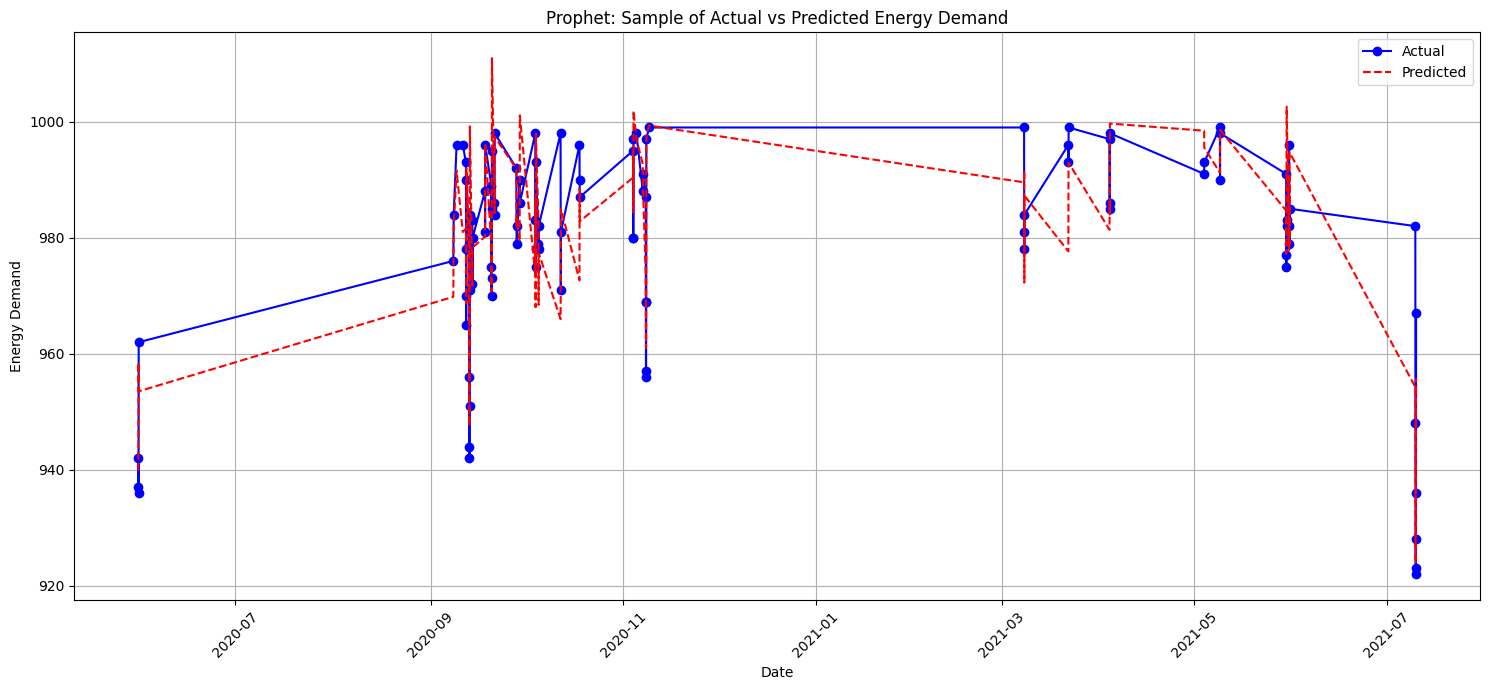


--- Plotting Prophet Components ---


KeyError: 'ds'

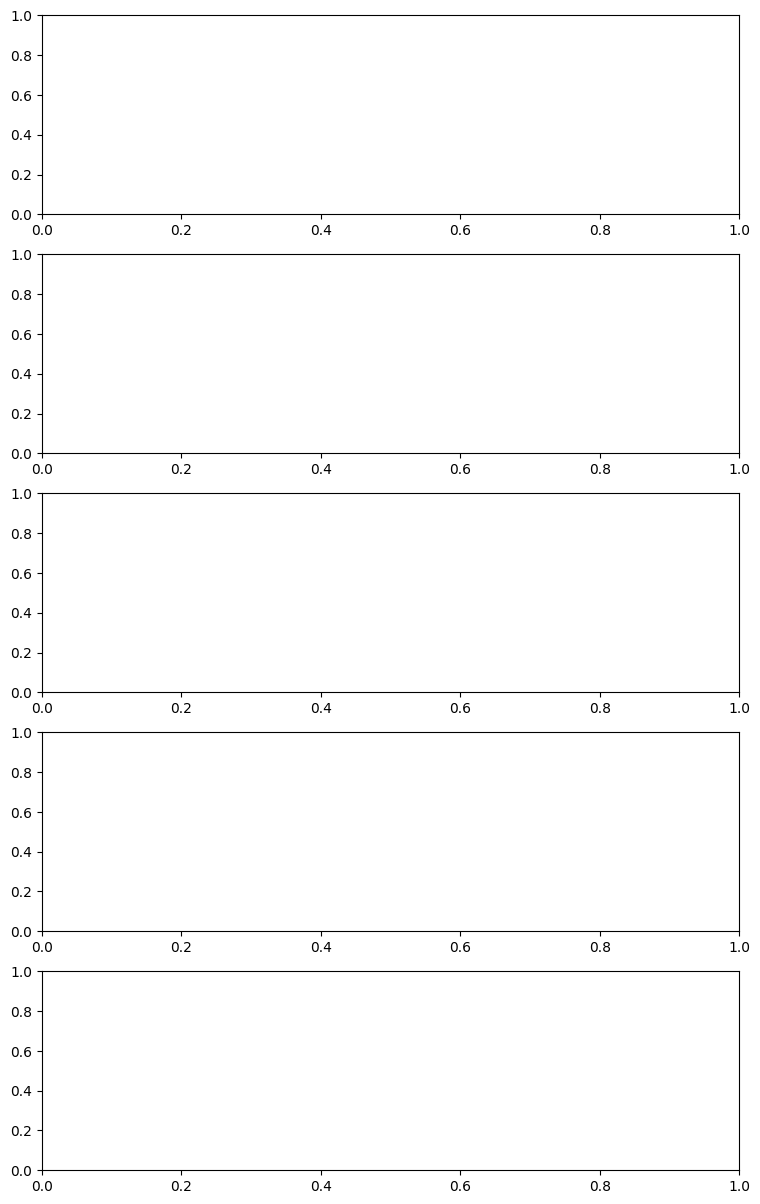

In [14]:
# Omaha Energy Demand Forecasting with Prophet (Updated & Corrected)
#
# This script uses Facebook's Prophet library for energy demand forecasting in Omaha.
#
# Updates:
# - Corrected a KeyError by manually calculating the 'horizon' column for metric evaluation.
# - Multi-Horizon Forecasting: Cross-validation is performed with a 24-hour horizon,
#   and performance metrics are calculated for 1, 6, 12, and 24-hour ahead forecasts.
# - Additional Metrics: Evaluation now includes MAE, MSE, RMSE, R², and a robust MAPE
#   for each specific forecast horizon.

#REMOVED TEMP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- 1. Data Loading and Feature Engineering ---
# Load the dataset
# Using CSV file since Excel file appears to be corrupted
try:
    data = pd.read_csv('Omaha.csv')
except FileNotFoundError:
    print("Error: 'Omaha.csv' not found. Please ensure the dataset is in the correct directory.")
    raise

# Convert time column to datetime
data['time'] = pd.to_datetime(data['time'])

# Convert Demand (MW) to numeric, handling any string values
data['Demand (MW)'] = pd.to_numeric(data['Demand (MW)'], errors='coerce')

# Remove rows where demand is missing
data = data.dropna(subset=['Demand (MW)'])

# Rename columns for Prophet
df = data.rename(columns={'time': 'ds', 'Demand (MW)': 'y'})

print(f"Data loaded successfully. Shape: {df.shape}")
print(f"Date range: {df['ds'].min()} to {df['ds'].max()}")
print(f"Demand range: {df['y'].min():.2f} to {df['y'].max():.2f} MW")

# Create time-based features
df['Hour'] = df['ds'].dt.hour
df['DayOfWeek'] = df['ds'].dt.dayofweek
df['Month'] = df['ds'].dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Create lag features
for lag in range(1, 25):
    df[f'Lag_{lag}'] = df['y'].shift(lag)

# Create interaction features
df['Temp_Humidity_Interaction'] = df['Temperature'] * df['RelativeHumidity']

df.dropna(inplace=True)

# --- 2. Prophet Model Training ---
model = Prophet()

# Add regressors
model.add_regressor('DewPoint')
model.add_regressor('WindSpeed')
model.add_regressor('Pressure')
model.add_regressor('RelativeHumidity')
model.add_regressor('Hour')
model.add_regressor('DayOfWeek')
model.add_regressor('Month')
model.add_regressor('IsWeekend')
model.add_regressor('Temp_Humidity_Interaction')

for lag in range(1, 25):
    model.add_regressor(f'Lag_{lag}')

print("--- Fitting Prophet Model ---")
model.fit(df)

# --- 3. Cross-Validation and Evaluation ---
print("\n--- Starting Cross-Validation ---")
# Check if we have enough data for cross-validation
total_days = (df['ds'].max() - df['ds'].min()).days
print(f"Total days of data: {total_days}")

# Adjust cross-validation parameters based on available data
if total_days < 400:
    initial_period = '180 days'
    period = '90 days'
    horizon = '12 hours'
    print("Adjusting cross-validation parameters for smaller dataset")
else:
    initial_period = '365 days'
    period = '180 days'
    horizon = '24 hours'

# Perform cross-validation
try:
    df_cv = cross_validation(model, initial=initial_period, period=period, horizon=horizon, parallel="processes")
except Exception as e:
    print(f"Cross-validation failed: {e}")
    print("Trying with smaller parameters...")
    df_cv = cross_validation(model, initial='90 days', period='30 days', horizon='6 hours', parallel="processes")

# Display aggregated performance metrics from Prophet
df_p = performance_metrics(df_cv)
print("\nCross-validation performance metrics (aggregated by Prophet):")
print(df_p.head())

# Define a robust MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    if np.sum(non_zero_indices) == 0:
        return 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

# Calculate and display metrics for our specific horizons
print("\n--- Performance Metrics for Specific Horizons ---")
# FIX: Calculate the 'horizon' column manually from 'ds' and 'cutoff'
df_cv['horizon'] = df_cv['ds'] - df_cv['cutoff']
df_cv['horizon_hours'] = df_cv['horizon'].dt.total_seconds() / 3600
horizons = [1, 6, 12, 24]

for h in horizons:
    df_h = df_cv[df_cv['horizon_hours'] == h]
    if not df_h.empty:
        mae = mean_absolute_error(df_h['y'], df_h['yhat'])
        mse = mean_squared_error(df_h['y'], df_h['yhat'])
        rmse = np.sqrt(mse)
        r2 = r2_score(df_h['y'], df_h['yhat'])
        mape = mean_absolute_percentage_error(df_h['y'], df_h['yhat'])

        print(f'\nHorizon: {h} hours')
        print(f'  MAE: {mae:.4f}')
        print(f'  MSE: {mse:.4f}')
        print(f'  RMSE: {rmse:.4f}')
        print(f'  R2 Score: {r2:.4f}')
        print(f'  MAPE: {mape:.4f}%')
    else:
        print(f'\nNo data for horizon: {h} hours')


# --- 4. Final Forecast and Plotting ---
print("\n--- Generating Final Forecast and Plots ---")
future = df.drop(columns=['y'])
forecast = model.predict(future)

# Join forecast with actuals for plotting
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)
aligned_df = df.join(forecast[['yhat']], how='inner')

# Plot a sample of the results
sample_period = 100
plt.figure(figsize=(15, 7))
plt.plot(aligned_df.index[-sample_period:], aligned_df['y'].iloc[-sample_period:], label='Actual', color='b', marker='o')
plt.plot(aligned_df.index[-sample_period:], aligned_df['yhat'].iloc[-sample_period:], label='Predicted', color='r', linestyle='--')
plt.title('Prophet: Sample of Actual vs Predicted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Prophet components
print("\n--- Plotting Prophet Components ---")
fig_components = model.plot_components(forecast)
plt.show()

